### Overview
In this optional notebook, if you have some time left, you can load our trained model to predict tissue types in an example whole slide image (WSI), which has been downloaded from The Cancer Genome Atlas (TCGA) colorectal cancer (CRC) cohort. 

### Imports

In [1]:
import torch
from torchvision import transforms
from model import SimpleCNN

from utils import *


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load pretrained model

In [3]:
ckpt = torch.load("best_model.pth", map_location="cpu")
classes = ckpt["classes"]
img_size = int(ckpt.get("img_size"))

In [4]:
model = SimpleCNN(len(classes))
model.load_state_dict(ckpt["state_dict"])
model.to(device).eval()

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=64, out_features=9, bias=True)
  )
)

### Load the WSI and read metadata

In [5]:
# the WSI in .svs format has been downloaded for you in the following path
WSI_PATH = "/data/cat/ws/lazi257c-come2data_workshop/data/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs" 

In [6]:
slide = openslide.OpenSlide(WSI_PATH)

In [7]:
# the WSI contains multiple levels
print(f"WSI dimensions: {slide.dimensions}")
print(f"Number of levels: {slide.level_count}")
print(f"Level dimensons: {slide.level_dimensions}")

WSI dimensions: (95615, 74462)
Number of levels: 4
Level dimensons: ((95615, 74462), (23903, 18615), (5975, 4653), (2987, 2326))


In [8]:
# it also contains a lot of other metadata
print(dict(slide.properties))

{'aperio.AppMag': '40', 'aperio.DSR ID': 'resc3-dsr1', 'aperio.Date': '11/19/14', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': 'TCGA-3L-AA1B-01Z-00-DX1', 'aperio.Focus Offset': '0.000000', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '164819', 'aperio.Left': '20.562956', 'aperio.LineAreaXOffset': '0.011464', 'aperio.LineAreaYOffset': '-0.002805', 'aperio.LineCameraSkew': '-0.000153', 'aperio.MPP': '0.2527', 'aperio.OriginalHeight': '74562', 'aperio.OriginalWidth': '97536', 'aperio.Parmset': 'GOG136', 'aperio.ScanScope ID': 'SS1764CNTLR', 'aperio.StripeWidth': '2032', 'aperio.Time': '17:24:10', 'aperio.Time Zone': 'GMT-05:00', 'aperio.Title': 'TCGA-3L-AA1B-01Z-00-DX1', 'aperio.Top': '24.159639', 'aperio.User': '79ba7f43-3d2d-48db-a92d-9bb62c29f510', 'openslide.associated.label.height': '652', 'openslide.associated.label.width': '663', 'openslide.associated.macro.height': '631', 'openslide.associated.macro.w

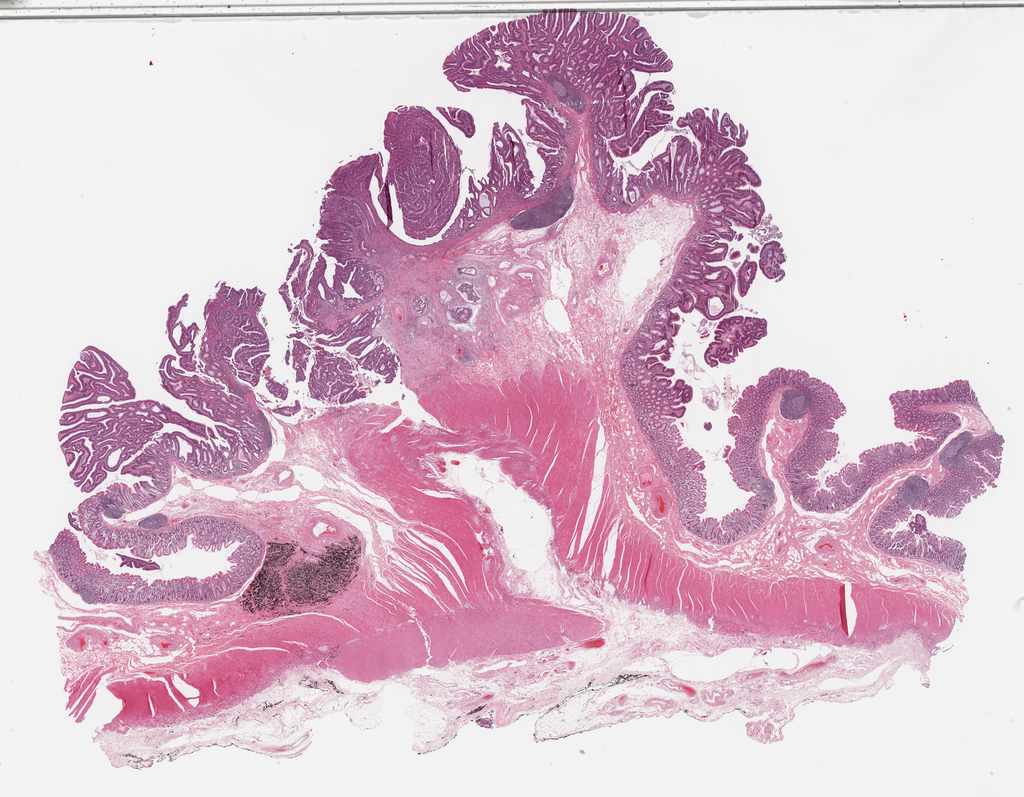

In [9]:
# we can visualize the thumbnail like this
slide.get_thumbnail(size=(1024,1024))

In [10]:
# now we define a helper function to extract the MPP (microns per pixel) value from the metadata of the WSI
def get_base_mpp(slide):
    mx = slide.properties.get(openslide.PROPERTY_NAME_MPP_X, None)
    my = slide.properties.get(openslide.PROPERTY_NAME_MPP_Y, None)
    return (float(mx) + float(my)) / 2.0

In [11]:
base_mpp = get_base_mpp(slide)   # level-0 MPP
print(f"Base MPP: {base_mpp}")

Base MPP: 0.2527


In order to apply the pretrained model on new tiles that we will extract from the WSI, we need to match the resolution of these new tiles to the resolution of the tiles the model has been trained on. We trained our model on 224 x 224 px tiles with 0.5 MPP (microns per pixel). Therefore, we set the target MPP to this value below:

In [12]:
TARGET_MPP = 0.5  # microns per pixel (0.5 μm/px)

In [13]:
# pick the level of the WSI closest to target MPP
downsample = TARGET_MPP / base_mpp   # factor vs level-0
level = slide.get_best_level_for_downsample(downsample)
eff_down = float(slide.level_downsamples[level])
eff_mpp = base_mpp * eff_down

w_level, h_level = slide.level_dimensions[level]
print(f"Chosen level {level}: size={w_level}x{h_level}, "f"downsample≈{eff_down:.2f}, effective MPP≈{eff_mpp:.3f} µm/px")

Chosen level 0: size=95615x74462, downsample≈1.00, effective MPP≈0.253 µm/px


### Make predictions
Now we use "run_tiled_inference" function, which will color normalize, downscale the WSI to the target MPP, tile it to 224 x 224 px tiles, and feed each tile into the model to make predictions.

In [14]:
probs_map_norm, probs_map_raw, mask_map = run_tiled_inference(
    slide=slide,
    level=level,
    w_level=w_level,
    h_level=h_level,
    eff_down=eff_down,
    classes=classes,
    model=model.to(device),
    tile_px=224,
    target_mpp=TARGET_MPP
)

Tessellate@level0 (read=443, step=443): 100%|██████████| 36504/36504 [04:51<00:00, 125.16it/s]


### Visualize a thumbnail and the prediction map

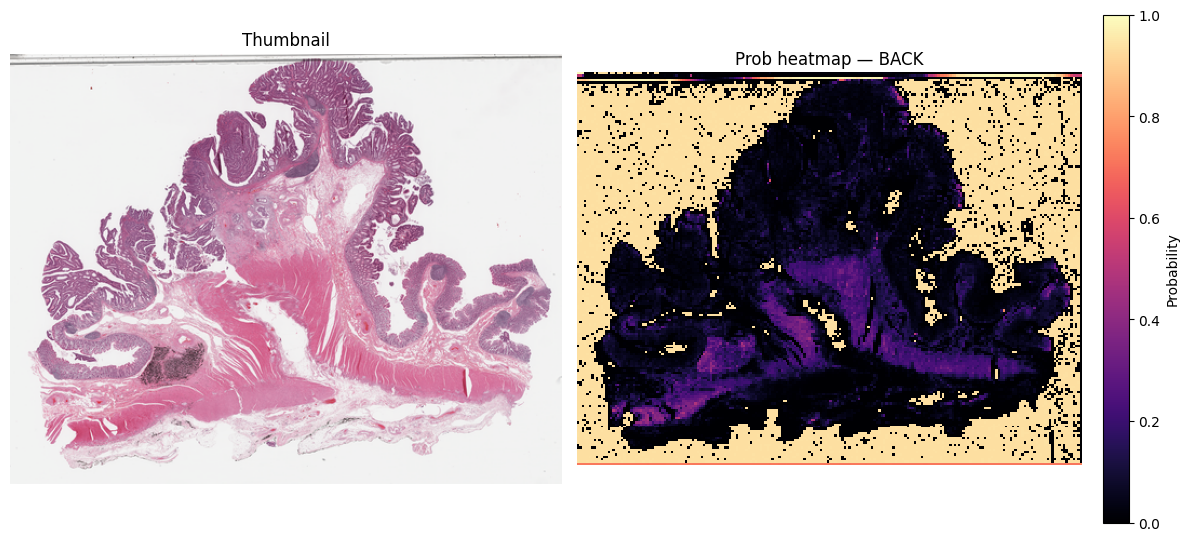

In [15]:
k = classes.index("BACK")
grid_k = probs_map_norm[:, :, k].astype(np.float32)  # rows×cols in [0,1]

thumb = small_thumbnail(slide, w_level, h_level)
vis_w, vis_h = thumb.size
heat_im = grid_to_vis(grid_k, (vis_w, vis_h))

# draw side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 12 * (vis_h / vis_w)))
ax[0].imshow(thumb)
ax[0].set_title("Thumbnail")
ax[0].axis("off")

hm = ax[1].imshow(np.asarray(heat_im, dtype=np.float32) / 255.0, cmap="magma", vmin=0, vmax=1, interpolation="nearest")
ax[1].set_title(f"Prob heatmap — {classes[k]}")
ax[1].axis("off")

# colorbar for the heatmap
cbar = fig.colorbar(hm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Probability")

plt.tight_layout()
plt.show()

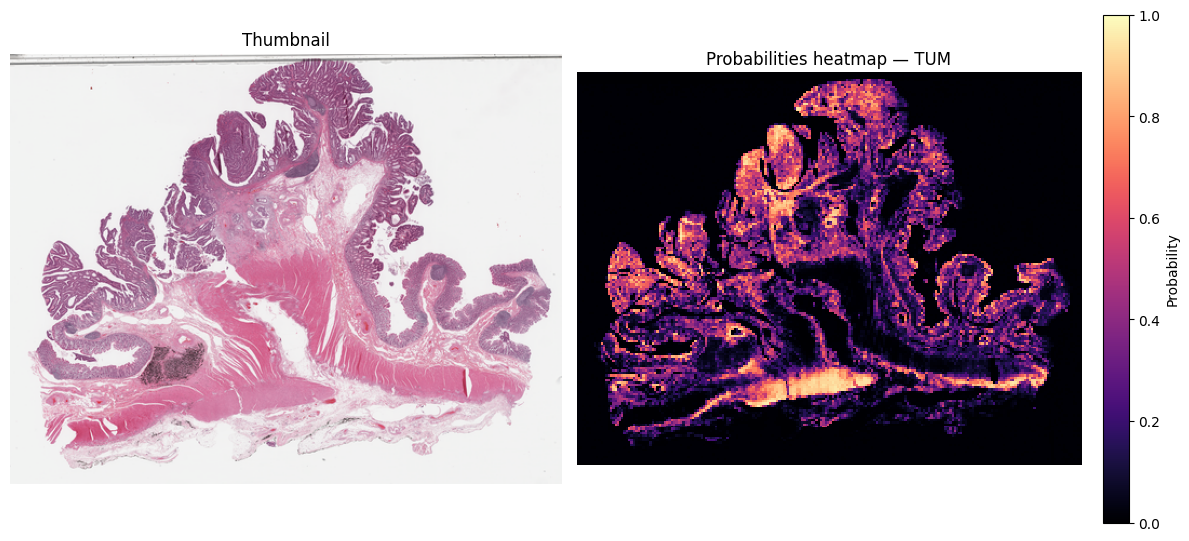

In [16]:
k = classes.index("TUM")
grid_k = probs_map_norm[:, :, k].astype(np.float32)  # rows×cols in [0,1]

thumb = small_thumbnail(slide, w_level, h_level)
vis_w, vis_h = thumb.size
heat_im = grid_to_vis(grid_k, (vis_w, vis_h))

# draw side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 12 * (vis_h / vis_w)))
ax[0].imshow(thumb)
ax[0].set_title("Thumbnail")
ax[0].axis("off")

hm = ax[1].imshow(np.asarray(heat_im, dtype=np.float32) / 255.0, cmap="magma", vmin=0, vmax=1, interpolation="nearest")
ax[1].set_title(f"Probabilities heatmap — {classes[k]}")
ax[1].axis("off")

# colorbar for the heatmap
cbar = fig.colorbar(hm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Probability")

plt.tight_layout()
plt.show()

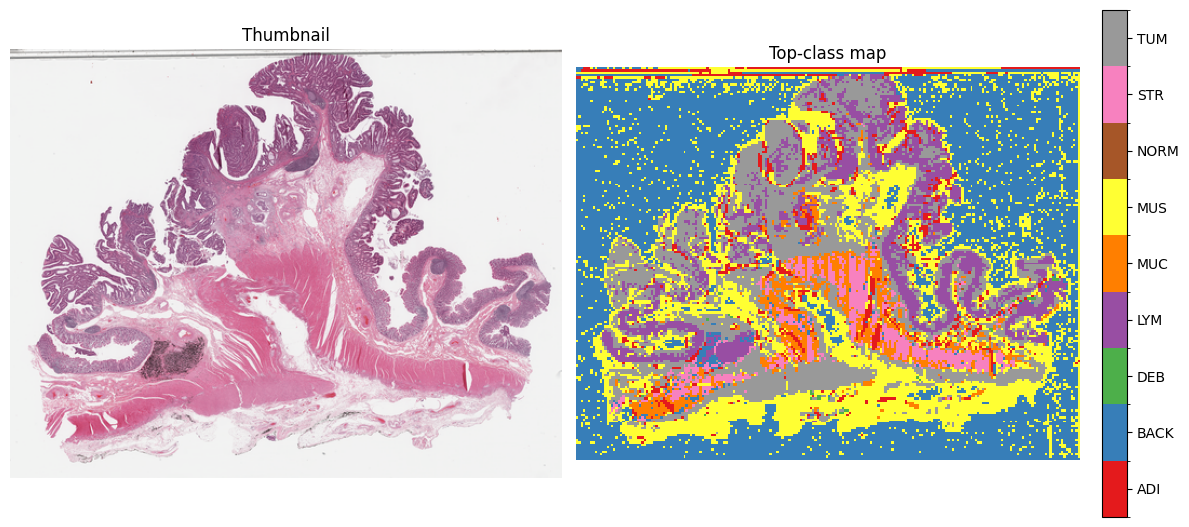

In [17]:
top_idx = probs_map_norm.argmax(axis=2).astype(np.int16)

n = len(classes)
base_colors = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#ffff33","#a65628","#f781bf","#999999"]
cmap = ListedColormap((base_colors * ((n+len(base_colors)-1)//len(base_colors)))[:n])
norm = BoundaryNorm(np.arange(-0.5, n+0.5, 1), cmap.N)

thumb = small_thumbnail(slide, w_level, h_level)
vis_w, vis_h = thumb.size
top_im = grid_to_vis(top_idx.astype(np.uint8), size_wh=(vis_w, vis_h))

fig, ax = plt.subplots(1, 2, figsize=(12, 12 * (vis_h / vis_w)))
ax[0].imshow(thumb); ax[0].set_title("Thumbnail"); ax[0].axis("off")

im = ax[1].imshow(np.asarray(top_im), cmap=cmap, norm=norm, interpolation="nearest")
ax[1].set_title("Top-class map"); ax[1].axis("off")

cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, ticks=np.arange(n))
cbar.ax.set_yticklabels(classes)
plt.tight_layout()
plt.show()